In [66]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [67]:
#  !pip install catboost
#  !pip install xgboost
#  !pip install lightgbm

# Оптимизация производственных расходов за счет снижения энергопотребления

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель:** Построить модель, которая предскажет температуру стали. 

**Описание технологического процесса:**  

1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы 
ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом.   
Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
2. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.   
Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).    
3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ.  
Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.   
4. Затем его перемешивают и снова проводят измерения.   

Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).  

**Описание данных**  

Данные состоят из файлов, полученных из разных источников:  
- `data_arc.csv` — данные об электродах; 
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём); 
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время); 
- `data_gas.csv` — данные о продувке сплава газом; 
- `data_temp.csv` — результаты измерения температуры; 
- `data_wire.csv` — данные о проволочных материалах (объём); 
- `data_wire_time.csv` — данные о проволочных материалах (время). 

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.  


Импорт библиотек:

In [249]:
import lightgbm as ltb
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb

from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

## План работы

**План решения задачи:**
1. Изучение данных.
2. Деление на обучающую и тренировочную выборки. Выделение целевого атрибута.
3. Попробывать провести Feature engineering, с целью создание дополнительных признаков.
4. Обучение нескольких моделей.
5. Выбор лучшей модели (MAE не более 7.6, но лучше ниже 6). Определение наиболее важных признаков.
5. Выводы ко всем разделам, описание выполняемых шагов.

## Изучение данных и исследовательский анализ данных

Прочитаем все данные:

In [70]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

### Данные об электродах

#### Изучение данных

Выведем общие данные о электродах:

In [71]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [72]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [73]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


#### Начальная обработка данных

Приведем к нужным типам атрибуты:

In [74]:
df_arc.columns = ['key', 'start_of_arc_heating', 'end_of_arc_heating',
       'active_power', 'reactive_power']

In [75]:
df_arc['start_of_arc_heating'] = pd.to_datetime(df_arc['start_of_arc_heating'], format='%Y-%m-%d  %H:%M:%S')
df_arc['end_of_arc_heating'] = pd.to_datetime(df_arc['end_of_arc_heating'], format='%Y-%m-%d  %H:%M:%S')

Посмотрим максимальное и минимальное время начала и окончания нагрева электрода:

In [76]:
df_arc['start_of_arc_heating'].min(), df_arc['start_of_arc_heating'].max()

(Timestamp('2019-05-03 11:02:14'), Timestamp('2019-09-01 04:34:47'))

In [77]:
df_arc['start_of_arc_heating'].max() - df_arc['start_of_arc_heating'].min()

Timedelta('120 days 17:32:33')

In [78]:
df_arc['end_of_arc_heating'].min(), df_arc['end_of_arc_heating'].max()

(Timestamp('2019-05-03 11:06:02'), Timestamp('2019-09-01 04:36:08'))

In [79]:
df_arc['end_of_arc_heating'].max() - df_arc['end_of_arc_heating'].min()

Timedelta('120 days 17:30:06')

Переведем время продолжительности нагрева в секунды:

In [80]:
df_arc['heating_duration'] = (df_arc['end_of_arc_heating'] - df_arc['start_of_arc_heating']).dt.seconds

Провериим партии, действительно ли во всех партиях использовали электроды:

In [81]:
len(df_arc['key'].unique())

3214

In [82]:
len(set(range(1, 3242)) - set(df_arc['key']))

27

#### Анализ данных

Посмотрим на распределение признаков

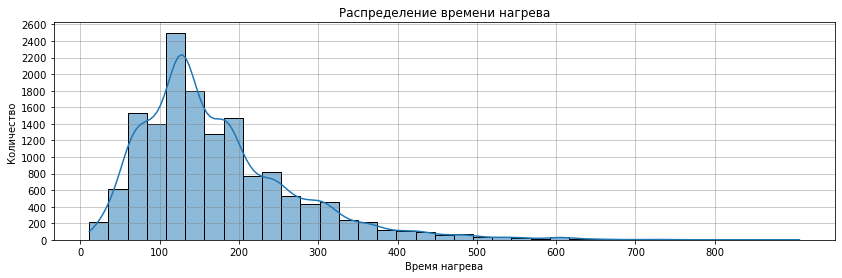

In [83]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="heating_duration", kde=True, bins=37)
plt.title('Распределение времени нагрева')
plt.ylabel('Количество')
plt.xlabel('Время нагрева')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 900, 100))
plt.yticks(np.arange(0, 2800, 200))
plt.show()

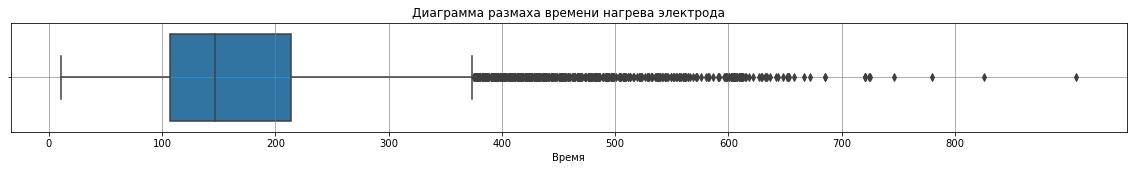

In [84]:
plt.rcParams['figure.figsize']=(20, 2)
sns.boxplot(x=df_arc['heating_duration'])
plt.title('Диаграмма размаха времени нагрева электрода')
plt.xlabel('Время')
plt.grid(color='grey', axis='both', alpha=.8)
plt.xticks(np.arange(0, 900, 100))
plt.show()

Посольку нам требуется сформировать агрегированную таблицу, нужно убрать значения откровенно, которые являются выбрасами, что мы и сделаем по 95 перцентилю

In [85]:
df_arc =  df_arc[df_arc['heating_duration'] <=
                 np.around(np.percentile(df_arc['heating_duration'], 95))]

Посмотрим на распределение активной мощности:

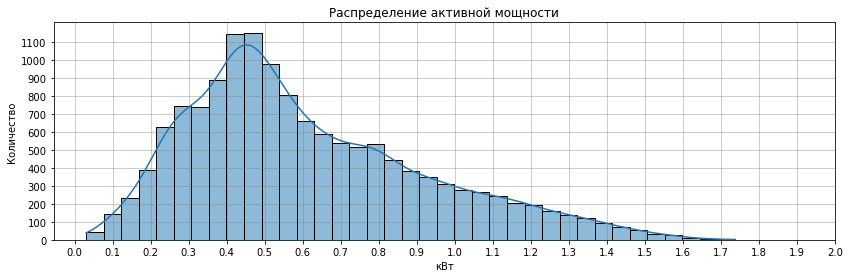

In [86]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="active_power", kde=True, bins=37)
plt.title('Распределение активной мощности')
plt.ylabel('Количество')
plt.xlabel('кВт')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 2.1, 0.1))
plt.yticks(np.arange(0, 1200, 100))
plt.show()

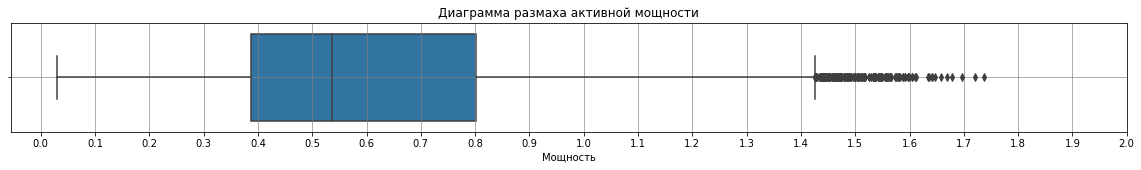

In [88]:
plt.rcParams['figure.figsize']=(20, 2)
sns.boxplot(x=df_arc['active_power'])
plt.title('Диаграмма размаха активной мощности')
plt.xlabel('Мощность')
plt.grid(color='grey', axis='both', alpha=.8)
plt.xticks(np.arange(0, 2.1, 0.1))
plt.show()

Также, уберем данные после 95 перцентиля:

In [32]:
df_arc =  df_arc[df_arc['active_power'] <= np.around(np.percentile(df_arc['active_power'], 95))]

Выведем граифк реактивной мощности:

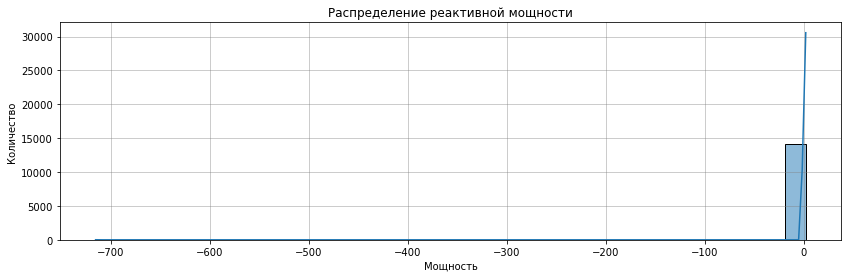

In [89]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="reactive_power", kde=True, bins=35)
plt.title('Распределение реактивной мощности')
plt.ylabel('Количество')
plt.xlabel('Мощность')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

Явно, виден выброс:

In [90]:
df_arc['reactive_power'].sort_values().head(4)

9780   -715.504924
5596      0.020806
2419      0.021154
4914      0.022485
Name: reactive_power, dtype: float64

Посмотрим на это значение:

In [91]:
df_arc[df_arc['reactive_power'] == min(df_arc['reactive_power'])]

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,heating_duration
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109


Заменим его на медианное значение (замена на медиану оправдана тем, что мы не избавимся от значения активной мощности, а также времени нагрева, и в тоже время минимально повлияем на распределение данных)

In [92]:
df_arc['reactive_power'] = df_arc['reactive_power'].replace(
    min(df_arc['reactive_power']), df_arc['reactive_power'].median())

Посмотрим, какое распределение у нас получсилось для реактивной мощности:

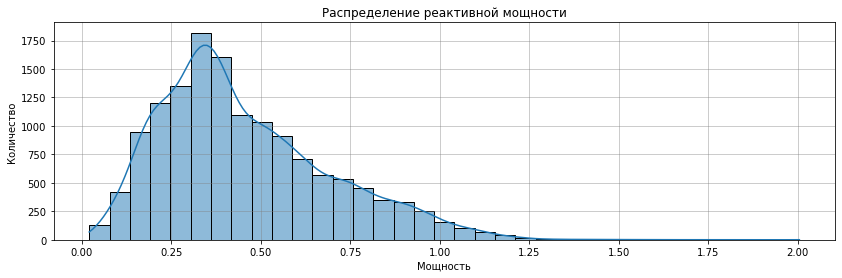

In [93]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_arc, x="reactive_power", kde=True, bins=35)
plt.title('Распределение реактивной мощности')
plt.ylabel('Количество')
plt.xlabel('Мощность')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

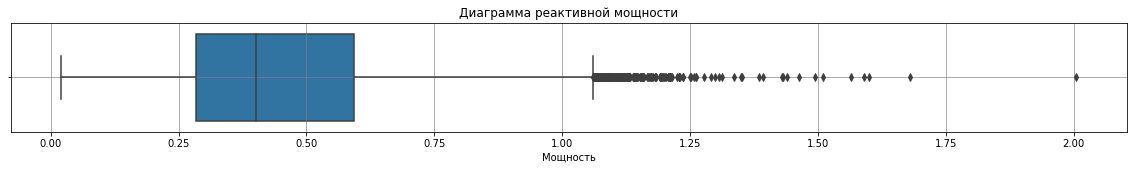

In [95]:
plt.rcParams['figure.figsize']=(20, 2)
sns.boxplot(x=df_arc['reactive_power'])
plt.title('Диаграмма реактивной мощности')
plt.xlabel('Мощность')
plt.grid(color='grey', axis='both', alpha=.8)
plt.show()

Также, с целью формирование итоговой агрегированной таблицы по электродам, удалим все выбросы по 95 перцентилю:

In [96]:
df_arc =  df_arc[df_arc['reactive_power'] <= np.around(np.percentile(df_arc['reactive_power'], 95))]

#### Агрегирование данных

Рассчитаем полную мощность [Ссылка](https://m-strana.ru/articles/aktivnaya-i-reaktivnaya-moshchnost/)

In [97]:
df_arc['full_power'] = np.sqrt(df_arc['active_power']**2 + df_arc['reactive_power']**2)

Рассчитем энергию [Ссылка](https://electric-220.ru/news/moshhnost_p_vremja_t_ehnergija_w/2017-05-28-1278)

In [98]:
df_arc['energy'] = df_arc['full_power'] * df_arc['heating_duration']

In [103]:
df_arc_group = df_arc.groupby('key')[
    ['active_power', 'reactive_power', 'heating_duration', 'full_power', 'energy']].sum().reset_index()

In [104]:
df_arc_group.corr().style.background_gradient(cmap='coolwarm')

,key,active_power,reactive_power,heating_duration,full_power,energy
key,1.000000,-0.053376,-0.025958,-0.051052,-0.043362,-0.058908
active_power,-0.053376,1.000000,0.963126,0.974993,0.994865,0.945089
reactive_power,-0.025958,0.963126,1.000000,0.967274,0.985310,0.919142
heating_duration,-0.051052,0.974993,0.967274,1.000000,0.980425,0.920896
full_power,-0.043362,0.994865,0.985310,0.980425,1.000000,0.943610
energy,-0.058908,0.945089,0.919142,0.920896,0.943610,1.000000


Наблюдается мультиколлинеарность, оставим только номер партии и энергию:

In [105]:
df_arc_group = df_arc_group[['key', 'energy']]

In [106]:
df_arc_group.head()

,key,energy
0,1,723.156360
1,2,881.233565
2,3,525.066777
3,4,796.911309
4,5,397.894477


#### Вывод

Провели предварительную обработку данных, анализ и агрегацию данных, таблицу по электродам подготовили.

### Данные о подаче сыпучих материалов (объём)

#### Изучение данных

In [107]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [108]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [109]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Видим большое количество пропусков в данных, при этом некоторе материалы совсем редко использовались.

#### Начальная обработка данных

In [129]:
df_bulk.columns = df_bulk.columns.str.replace(' ','_').str.lower()

In [111]:
len(set(range(1, 3242)) - set(df_bulk['key']))

112

In [112]:
df_bulk = df_bulk.fillna(0)

Создадим признак с общей суммой всех добавляемых в партии материалов

In [113]:
df_bulk['bulk_sum'] = df_bulk.drop('key', axis=1).sum(axis=1)

Создадим признак коэффециент самых используемых материалов к общей сумме:

In [115]:
df_bulk['ratio_bulk_sum'] = df_bulk[['bulk_12', 'bulk_14', 'bulk_15']].sum(axis=1) / df_bulk.drop(['key','bulk_12', 'bulk_14', 'bulk_15'], axis=1).sum(axis=1)

Отберем только те признаки, где материалы наиболее встречаются, а также наши новые признаки:

In [118]:
df_bulk = df_bulk[['key', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'ratio_bulk_sum', 'bulk_sum']]

In [119]:
df_bulk.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,ratio_bulk_sum,bulk_sum
0,1,0.0,43.0,206.0,150.0,154.0,0.855705,553.0
1,2,0.0,73.0,206.0,149.0,154.0,0.777099,582.0
2,3,0.0,34.0,205.0,152.0,153.0,0.882353,544.0
3,4,0.0,81.0,207.0,153.0,154.0,0.760355,595.0
4,5,0.0,78.0,203.0,151.0,152.0,0.764350,584.0


#### Вывод

Выбраны наиболее часто используемые материалы, добавлены два признака.

### Данные о подаче сыпучих материалов (время)

#### Изучение данных

In [120]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [121]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


#### Начальная обработка данных

Заполним пропуск датой 1900-01-01, нужно для дальнейшей работы:

In [122]:
df_bulk_time = df_bulk_time.fillna(pd.Timestamp('19000101'))

In [123]:
df_bulk_time.columns = df_bulk_time.columns.str.replace(' ','_').str.lower()

Приведем даты к формату datetime:

In [127]:
for i in range(1, 16):
  df_bulk_time[f"bulk_{i}"] = pd.to_datetime(df_bulk_time[f"bulk_{i}"], format='%Y-%m-%d  %H:%M:%S')

Посмотрим на количество промущенных партий:

In [128]:
len(set(range(1, 3242)) - set(df_bulk_time['key']))

112

#### Вывод

Время подачи материалов может пригодиться для определения тех партий, где материал засыпали, после измерения конечной температуры. Что поможет исключить эти партии.

### Данные о проволочных материалах (объём)

#### Изучение данных

In [130]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


#### Начальная обработка данных

In [133]:
df_wire.columns = df_wire.columns.str.replace(' ','_').str.lower()

In [134]:
len(set(range(1, 3242)) - set(df_wire['key']))

160

In [135]:
df_wire = df_wire.fillna(0)

Добавим новый признак, сумма всех проволочных материалов в партии, а также отберем наиболее значимые признаки, с точки зрения добавления по объему, а также наш новый признак

In [136]:
df_wire['wire_sum'] = df_wire.drop('key', axis=1).sum(axis=1)

In [137]:
df_wire = df_wire[['key', 'wire_1', 'wire_2', 'wire_sum']]

In [138]:
df_wire.head()

,key,wire_1,wire_2,wire_sum
0,1,60.059998,0.00000,60.059998
1,2,96.052315,0.00000,96.052315
2,3,91.160157,0.00000,91.160157
3,4,89.063515,0.00000,89.063515
4,5,89.238236,9.11456,98.352796


#### Вывод

Выбраны самые самые массовые проволочные материалы, а также добавлен признак сумма всех проволочных материалов в партии

### Данные о проволочных материалах (время)

#### Изучение данных

In [139]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


#### Начальная обработка данных

Заполним пропуск датой 1900-01-01, нужно для дальнейшей работы:

In [141]:
df_wire_time = df_wire_time.fillna(pd.Timestamp('19000101'))

In [142]:
df_wire_time.columns = df_wire_time.columns.str.replace(' ','_').str.lower()

Приведем даты к формату datetime:

In [143]:
for i in range(1, 10):
  df_wire_time[f"wire_{i}"] = pd.to_datetime(df_wire_time[f"wire_{i}"], format='%Y-%m-%d  %H:%M:%S')

In [144]:
len(set(range(1, 3242)) - set(df_wire_time['key']))

160

#### Вывод

Время подачи материалов может пригодиться для определения тех партий, где материал засыпали, после измерения конечной температуры. Что поможет исключить эти партии.

### Данные о продувке сплава газом

#### Изучение данных

In [145]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [146]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


#### Начальная обработка данных

In [147]:
df_gas.columns = ['key', 'gas_1']

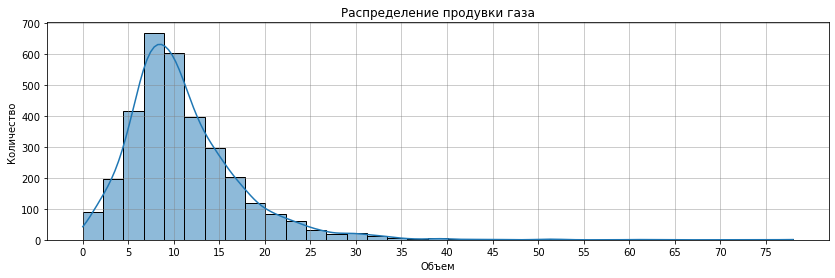

In [150]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_gas, x="gas_1", kde=True, bins=35)
plt.title('Распределение продувки газа')
plt.ylabel('Количество')
plt.xlabel('Объем')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 80, 5))
plt.yticks(np.arange(0, 800, 100))
plt.show()

In [151]:
len(set(range(1, 3242)) - set(df_gas['key']))

2

In [152]:
df_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


#### Вывод 

Данные по газу имеют небольшие выбросы, с которыми мы поработаем в дальше. При этом, газом продувались почти все партии, только 2 не продувались.

### Результаты измерения температуры

#### Изучение данных

In [153]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [154]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Приведем название колонок в нужный вид и к нужнему типу данных:

In [155]:
df_temp.columns = ['key', 'sample_time', 'temperature']

In [156]:
df_temp['sample_time'] = pd.to_datetime(df_temp['sample_time'], format='%Y-%m-%d  %H:%M:%S')

#### Партии с материалами после последнего замера температуры 

Определим те партии, в которых засыпали материалы после замера температуры:

Сыпучие материалы:

In [167]:
df_bulk_time.sample(1)

,key,max_bulk_time
499,526,2019-05-22 20:23:52


In [168]:
df_bulk_time['max_bulk_time'] = df_bulk_time.drop('key', axis=1).max(axis=1, skipna=True, numeric_only=False)

In [169]:
df_bulk_time = df_bulk_time[['key', 'max_bulk_time']]

Проволочные материалы:

In [170]:
df_wire_time.sample(1)

,key,max_wire_time
1315,1386,2019-06-22 10:14:02


In [171]:
df_wire_time['max_wire_time'] = df_wire_time.drop('key', axis=1).max(axis=1, skipna=True, numeric_only=False)

In [172]:
df_wire_time = df_wire_time[['key', 'max_wire_time']]

Сгруппируем по последнему времени замера температуры:

In [173]:
df_temp_group_time = df_temp.groupby('key')['sample_time'].max().reset_index()

Джойним данные по температуре, временем подачи материалов:

In [174]:
df_temp_group_time = df_temp_group_time.merge(df_bulk_time, on='key', how='left')
df_temp_group_time = df_temp_group_time.merge(df_wire_time, on='key', how='left')
df_temp_group_time.head()

,key,sample_time,max_bulk_time,max_wire_time
0,1,2019-05-03 11:30:39,2019-05-03 11:21:30,2019-05-03 11:11:41
1,2,2019-05-03 11:59:12,2019-05-03 11:46:38,2019-05-03 11:46:10
2,3,2019-05-03 12:34:57,2019-05-03 12:31:06,2019-05-03 12:13:47
3,4,2019-05-03 12:59:25,2019-05-03 12:48:43,2019-05-03 12:48:05
4,5,2019-05-03 13:36:01,2019-05-03 13:18:50,2019-05-03 13:32:06


Проведем логическую индексацию для определения партий

In [175]:
df_temp_group_time_bad_key = df_temp_group_time[(df_temp_group_time['sample_time'] < df_temp_group_time['max_bulk_time']) | 
                   (df_temp_group_time['sample_time'] < df_temp_group_time['max_wire_time'])]
df_temp_group_time_bad_key

,key,sample_time,max_bulk_time,max_wire_time
578,586,2019-05-25 01:28:18,2019-05-25 01:29:11,2019-05-25 01:17:33
1231,1244,2019-06-17 08:45:16,2019-06-17 08:49:23,2019-06-17 08:49:29
1302,1316,2019-06-19 17:34:42,2019-06-19 17:35:26,2019-06-19 17:23:55
1478,1493,2019-06-26 06:47:47,2019-06-26 06:51:49,2019-06-26 06:37:40
1490,1505,2019-06-26 14:14:29,2019-06-26 14:17:30,2019-06-26 14:18:01
1534,1549,2019-06-28 05:32:46,2019-06-28 05:33:18,2019-06-28 05:21:40
1858,1873,2019-07-08 22:09:51,2019-07-08 22:13:14,2019-07-08 22:00:47
2120,2137,2019-07-24 16:53:42,2019-07-24 16:53:54,2019-07-24 16:35:46
2401,2421,2019-08-03 09:06:23,2019-08-03 09:06:24,2019-08-03 08:54:27
2644,2667,2019-08-12 04:35:21,2019-08-12 04:35:33,2019-08-12 04:24:19


Посмотрим на некоторые из этих партий

In [176]:
df_temp[(df_temp['key'] == 2667) | (df_temp['key'] == 586)]

,key,sample_time,temperature
2999,586,2019-05-25 01:15:23,1594.0
3000,586,2019-05-25 01:23:27,1582.0
3001,586,2019-05-25 01:28:18,1594.0
13121,2667,2019-08-12 04:19:16,1583.0
13122,2667,2019-08-12 04:28:00,NaN
13123,2667,2019-08-12 04:35:21,NaN


Отфильтруем "плохие" партии:

In [177]:
df_temp = df_temp[~df_temp['key'].isin(list(df_temp_group_time_bad_key['key'].values))]

#### Начальная обработка данных

Перед агрегацией хороши убрать явные выбросы из данных, для этого посмотрим на них

Оценка количества партий:

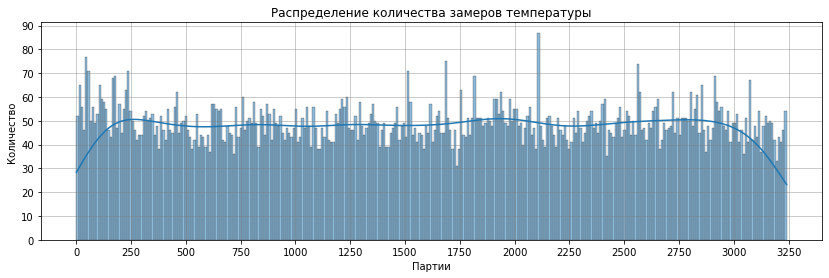

In [186]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_temp, x="key", kde=True, bins=322)
plt.title('Распределение количества замеров температуры')
plt.ylabel('Количество')
plt.xlabel('Партии')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 3500, 250))
plt.yticks(np.arange(0, 100, 10))
plt.show()

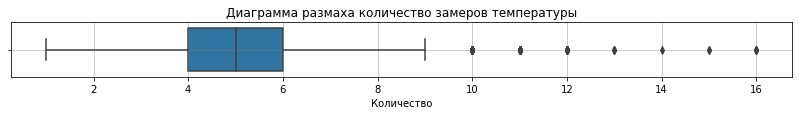

In [187]:
plt.figure(figsize=(14, 1))
sns.boxplot(x=df_temp.groupby('key')['key'].agg('count'))
plt.title('Диаграмма размаха количество замеров температуры')
plt.xlabel('Количество')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

Видим явные выбросы, в которых число замеров было более 10, посмотрим на них

In [188]:
df_bad_key = df_temp['key'].value_counts().reset_index()[
    df_temp['key'].value_counts().reset_index()['key'] >= 10]['index']

Выведем их количество в данных:

In [189]:
len(df_bad_key) / len(df_temp['key'].value_counts().reset_index())

0.022457891453524642

Их около 2 %, удалим данные партии

In [190]:
for i in df_bad_key:
    df_temp = df_temp[df_temp['key'] != i]

Оценка времени замеров:

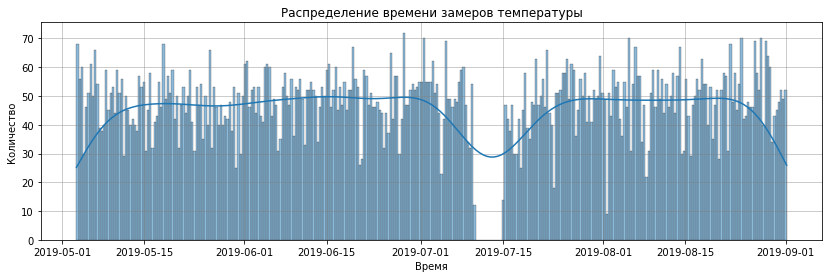

In [193]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_temp, x="sample_time", kde=True, bins=322)
plt.title('Распределение времени замеров температуры')
plt.ylabel('Количество')
plt.xlabel('Время')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

Видим какой-то перерым по времени замеров температуры

Оценка измеряемой температуры:

Число плавок, где замеряли только один раз температуру:

In [194]:
len(df_temp[df_temp['temperature'].isna()].groupby('key'))

723

Данные парти требуется отбросить, так как они не дают нам никаких вариантов для предсказания.

In [195]:
one_temp_meas = list(df_temp[df_temp['temperature'].isna()].
                                   groupby('key')['temperature'].count().index)

In [196]:
df_temp = df_temp[~df_temp['key'].isin(one_temp_meas)]

In [197]:
df_temp['temperature'].isna().sum()

0

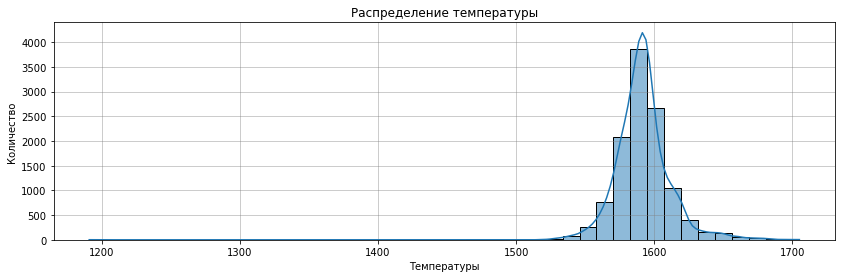

In [201]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_temp, x="temperature", kde=True, bins=42)
plt.title('Распределение температуры')
plt.ylabel('Количество')
plt.xlabel('Температуры')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

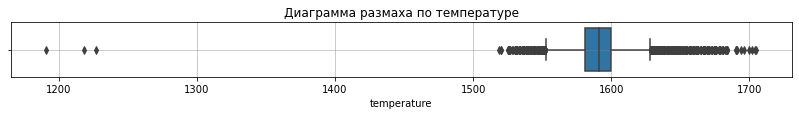

In [202]:
plt.figure(figsize=(14, 1))
sns.boxplot(x=df_temp['temperature'])
plt.title('Диаграмма размаха по температуре')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.show()

In [200]:
df_temp['temperature'].describe()

count    11577.000000
mean      1591.803490
std         20.231371
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1600.000000
max       1705.000000
Name: temperature, dtype: float64

Видны выбросы измеряемой температуры, в том числе ниже плавления стали [Ссылка](https://nerzhaveyka-spb.ru/temperatura-plavleniya-nerzhaveyushhej-stali/)

In [205]:
(len(df_temp) - len(df_temp[(df_temp['temperature'] >= 1540) & (df_temp['temperature'] <= 1620)])) / len(df_temp)

0.0

Околок 6 % выбросов, удалим их

In [204]:
df_temp = df_temp[(df_temp['temperature'] >= 1540) & (df_temp['temperature'] <= 1620)]

Посмотрим на количество партий, в которых не делались замеры температуры:

In [206]:
len(set(range(1, 3242)) - set(df_temp['key']))

891

Достатчно большое количество пропущенных партий, возможно технологический цикл

#### Агрегация данных о измерении температуры

Сгруппируем данные:

In [207]:
df_temp_group = pd.pivot_table(df_temp, values=['sample_time', 'temperature'], index=['key'],
                    aggfunc={'sample_time': [np.min, np.max, 'count'],
                             'temperature': [np.min, np.max, np.mean, 'first', 'last']}).reset_index()

In [208]:
df_temp_group.columns = df_temp_group.columns.droplevel(0)
df_temp_group.columns = ['key', 'time_first', 'time_last', 'count', 'temp_min', 'temp_max','temp_first', 'temp_last', 'temp_mean']

In [209]:
df_temp_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         2350 non-null   int64         
 1   time_first  2350 non-null   datetime64[ns]
 2   time_last   2350 non-null   datetime64[ns]
 3   count       2350 non-null   int64         
 4   temp_min    2350 non-null   float64       
 5   temp_max    2350 non-null   float64       
 6   temp_first  2350 non-null   float64       
 7   temp_last   2350 non-null   float64       
 8   temp_mean   2350 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2)
memory usage: 165.4 KB


Добавим продолжительность измерения

In [210]:
df_temp_group['duration_temp_meas'] = (df_temp_group['time_first'] - df_temp_group['time_last']).dt.seconds

In [211]:
df_temp_group = df_temp_group[['key', 'count', 'temp_min', 'temp_max', 'temp_mean', 
                               'temp_first', 'temp_last', 'duration_temp_meas']]

In [212]:
df_temp_group.corr().style.background_gradient(cmap='coolwarm')

,key,count,temp_min,temp_max,temp_mean,temp_first,temp_last,duration_temp_meas
key,1.000000,-0.057199,-0.078829,-0.058381,-0.082456,-0.035489,-0.096831,-0.017099
count,-0.057199,1.000000,0.153193,-0.109406,0.017659,0.059022,-0.009355,0.517738
temp_min,-0.078829,0.153193,1.000000,0.625315,0.880142,0.701135,0.731599,0.240932
temp_max,-0.058381,-0.109406,0.625315,1.000000,0.875099,0.843128,0.511098,-0.023391
temp_mean,-0.082456,0.017659,0.880142,0.875099,1.000000,0.795930,0.748311,0.107426
temp_first,-0.035489,0.059022,0.701135,0.843128,0.795930,1.000000,0.322295,0.147701
temp_last,-0.096831,-0.009355,0.731599,0.511098,0.748311,0.322295,1.000000,0.091546
duration_temp_meas,-0.017099,0.517738,0.240932,-0.023391,0.107426,0.147701,0.091546,1.000000


Есть небольшая корреляция между количеством замеров и продолжительностью замеров в партиях, что в целом логично, но удалять не будем, оставим оба признака

In [217]:
df_temp_group = df_temp_group[['key', 'count','temp_first', 'temp_last', 
                              'temp_min', 'temp_max', 'temp_mean', 'duration_temp_meas']]

In [218]:
df_temp_group.head()

,key,count,temp_first,temp_last,temp_min,temp_max,temp_mean,duration_temp_meas
0,1,5,1571.0,1613.0,1618.0,1571.0,1601.4,861
1,2,6,1581.0,1602.0,1608.0,1577.0,1593.5,1305
2,3,5,1596.0,1599.0,1599.0,1596.0,1597.8,1300
3,4,1,1601.0,1601.0,1601.0,1601.0,1601.0,0
4,5,2,1576.0,1602.0,1602.0,1576.0,1589.0,762


#### Вывод 

Провери обработку партий, в которых делали последний замер температуры, до последней подачи материалов. Убрали выбросы. Проверили агрегацию данных о измерении температуру, с созданием новых признаков.

## Предобработка данных

### Объеденение DataFrames

In [219]:
df_list = [df_bulk, df_gas, df_wire]

In [220]:
df = df_temp_group.merge(df_arc_group, on='key', how='left')
for i in df_list:
  df = df.merge(i, on='key', how='left')

Выведем полученную таблицу

In [222]:
df.head()

,key,count,temp_first,temp_last,temp_min,temp_max,temp_mean,duration_temp_meas,energy,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,ratio_bulk_sum,bulk_sum,gas_1,wire_1,wire_2,wire_sum
0,1,5,1571.0,1613.0,1618.0,1571.0,1601.4,861,723.156360,0.0,43.0,206.0,150.0,154.0,0.855705,553.0,29.749986,60.059998,0.00000,60.059998
1,2,6,1581.0,1602.0,1608.0,1577.0,1593.5,1305,881.233565,0.0,73.0,206.0,149.0,154.0,0.777099,582.0,12.555561,96.052315,0.00000,96.052315
2,3,5,1596.0,1599.0,1599.0,1596.0,1597.8,1300,525.066777,0.0,34.0,205.0,152.0,153.0,0.882353,544.0,28.554793,91.160157,0.00000,91.160157
3,4,1,1601.0,1601.0,1601.0,1601.0,1601.0,0,796.911309,0.0,81.0,207.0,153.0,154.0,0.760355,595.0,18.841219,89.063515,0.00000,89.063515
4,5,2,1576.0,1602.0,1602.0,1576.0,1589.0,762,397.894477,0.0,78.0,203.0,151.0,152.0,0.764350,584.0,5.413692,89.238236,9.11456,98.352796


Проверим на пропуски:

In [224]:
df.isna().sum().sort_values(ascending=False).unique()

array([53, 43,  2,  0])

### Пропущеные значения, аномальные данные

Выведем пропущенные значения:

In [226]:
df[df.isna().any(axis=1)].head()

,key,count,temp_first,temp_last,temp_min,temp_max,temp_mean,duration_temp_meas,energy,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,ratio_bulk_sum,bulk_sum,gas_1,wire_1,wire_2,wire_sum
44,51,1,1619.0,1619.0,1619.0,1619.0,1619.0,0,101.712300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.236758,NaN,NaN,NaN
45,52,1,1617.0,1617.0,1617.0,1617.0,1617.0,0,682.774519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.119615,NaN,NaN,NaN
46,55,1,1615.0,1615.0,1615.0,1615.0,1615.0,0,169.698680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.915683,NaN,NaN,NaN
62,72,2,1590.0,1595.0,1595.0,1590.0,1592.5,465,135.514480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.377227,71.853601,0.0,71.853601
69,80,4,1559.0,1580.0,1583.0,1559.0,1574.0,1050,613.072129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.693344,23.150400,0.0,23.150400


In [229]:
df.isna().sum()

key                    0
count                  0
temp_first             0
temp_last              0
temp_min               0
temp_max               0
temp_mean              0
duration_temp_meas     0
energy                 2
bulk_3                53
bulk_4                53
bulk_12               53
bulk_14               53
bulk_15               53
ratio_bulk_sum        53
bulk_sum              53
gas_1                  2
wire_1                43
wire_2                43
wire_sum              43
dtype: int64

Как видно это в основном материалы, удалим эти партии,  так не было присадок и из количество не большое:

In [230]:
df = df.dropna()

In [231]:
max(df.isna().sum())

0

Посмотрим есть ли мультиколлинеарность

In [234]:
df.corr().style.background_gradient(cmap='cividis')

,key,count,temp_first,temp_last,temp_min,temp_max,temp_mean,duration_temp_meas,energy,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,ratio_bulk_sum,bulk_sum,gas_1,wire_1,wire_2,wire_sum
key,1.000000,-0.071624,-0.035599,-0.097009,-0.082452,-0.054458,-0.081711,-0.025453,-0.054910,-0.010146,-0.024759,0.029024,-0.103876,-0.048908,-0.035455,-0.025946,-0.040264,-0.019601,0.049023,-0.006458
count,-0.071624,1.000000,0.089783,0.022407,0.178081,-0.065967,0.058803,0.499204,0.190310,0.060256,-0.036202,0.063590,0.110425,0.002350,0.006452,0.106844,0.252293,0.120576,0.045741,0.147908
temp_first,-0.035599,0.089783,1.000000,0.299112,0.693701,0.840908,0.790039,0.174760,-0.335575,-0.112489,0.147381,-0.073371,-0.148799,-0.031613,-0.041857,-0.107394,0.021077,0.261424,-0.098028,0.114749
temp_last,-0.097009,0.022407,0.299112,1.000000,0.724222,0.488283,0.735942,0.117082,0.193429,-0.033544,0.196957,0.254598,0.101617,0.269489,0.161414,0.223165,0.068604,0.310330,-0.221858,0.069155
temp_min,-0.082452,0.178081,0.693701,0.724222,1.000000,0.618740,0.879760,0.260572,-0.061329,-0.080059,0.205456,0.136569,-0.012167,0.153538,0.061221,0.106041,0.111488,0.357734,-0.187355,0.141774
temp_max,-0.054458,-0.065967,0.840908,0.488283,0.618740,1.000000,0.869624,0.014455,-0.313855,-0.112557,0.158987,-0.059569,-0.127879,0.015681,0.000248,-0.100832,-0.047775,0.237445,-0.145858,0.047857
temp_mean,-0.081711,0.058803,0.790039,0.735942,0.879760,0.869624,1.000000,0.141950,-0.172973,-0.093653,0.199654,0.072928,-0.046389,0.119544,0.050027,0.038069,0.049155,0.333285,-0.196360,0.105238
duration_temp_meas,-0.025453,0.499204,0.174760,0.117082,0.260572,0.014455,0.141950,1.000000,0.276859,0.046492,-0.010695,0.218079,0.196765,0.155405,0.072369,0.288257,0.407548,0.194316,0.053918,0.198003
energy,-0.054910,0.190310,-0.335575,0.193429,-0.061329,-0.313855,-0.172973,0.276859,1.000000,0.113907,-0.029130,0.246883,0.261057,0.230395,0.170161,0.331582,0.243044,0.044288,0.073462,0.100407
bulk_3,-0.010146,0.060256,-0.112489,-0.033544,-0.080059,-0.112557,-0.093653,0.046492,0.113907,1.000000,-0.295446,0.015486,0.004174,-0.018053,-0.291891,0.209413,0.066040,0.031577,0.087627,0.071784


Удалим признаки коллинераные друг к другу:

In [235]:
df = df.drop(['temp_min', 'temp_mean', 'count', 'temp_max', 'bulk_sum' ], axis=1)

Для анализа аномальных значений, посмтроим диаграммы размаха для каждого оставшевшиего признака, и попробуем убрать выбросы:

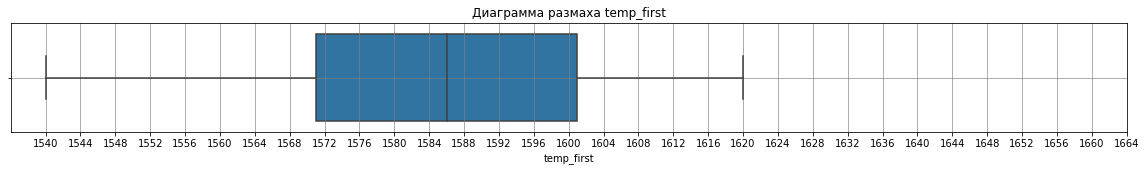

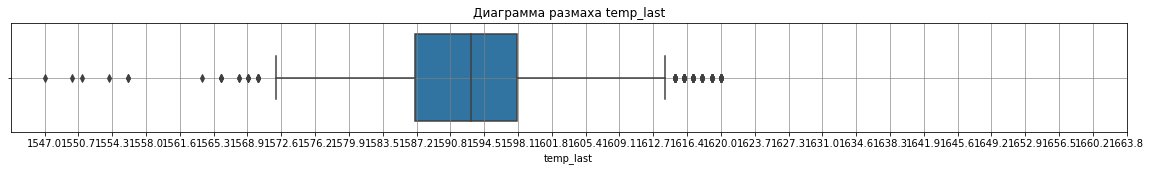

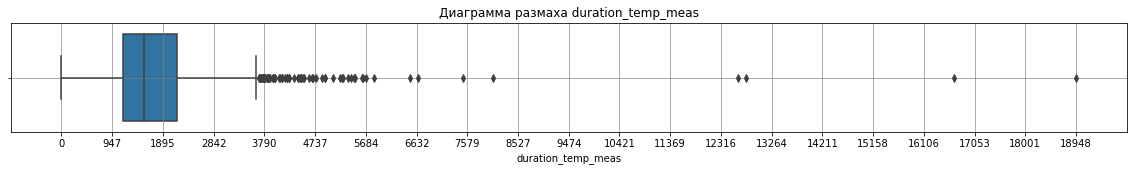

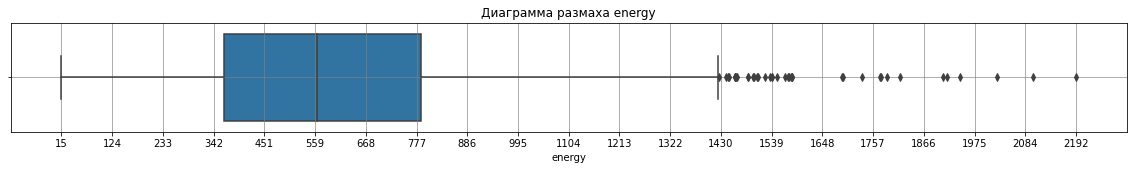

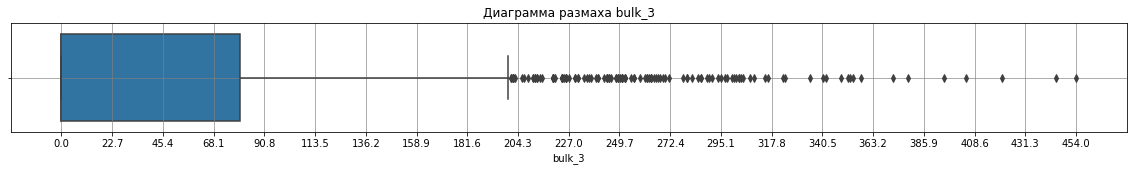

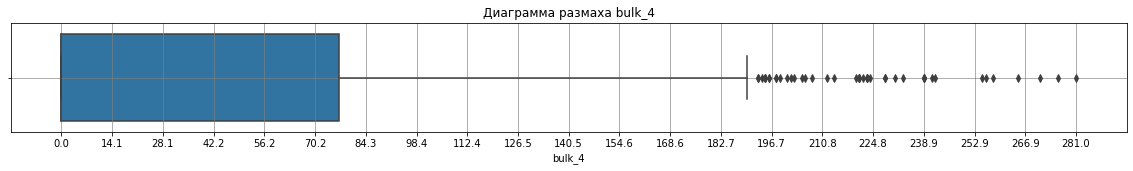

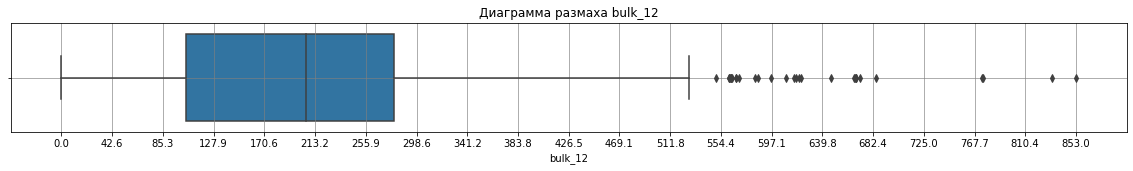

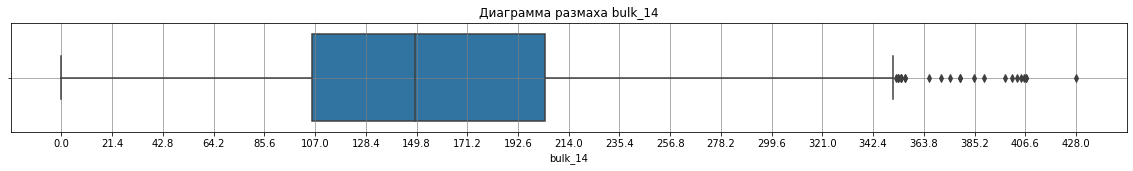

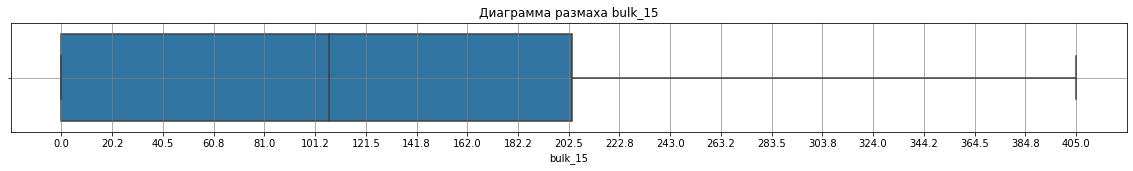

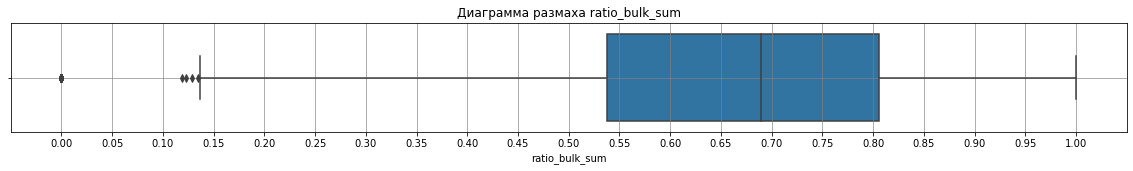

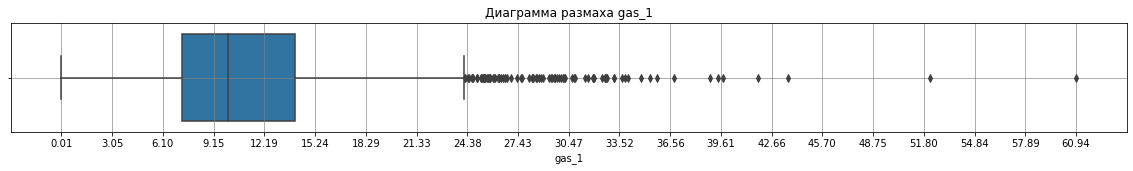

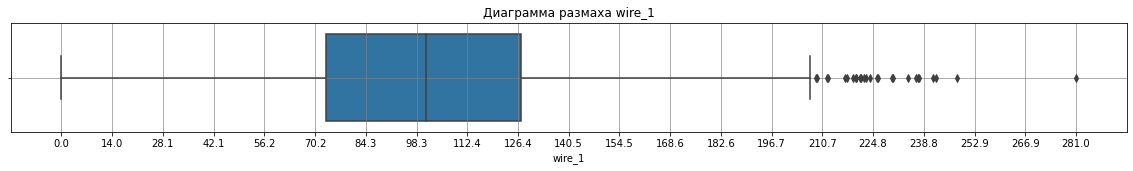

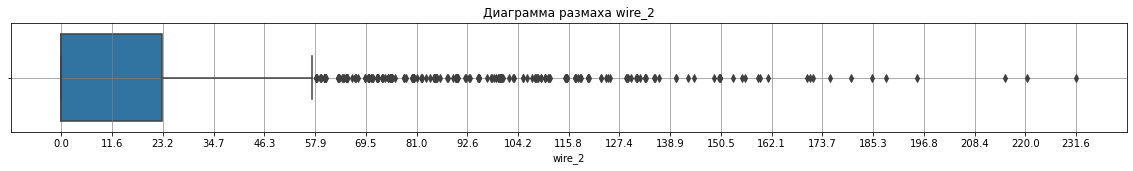

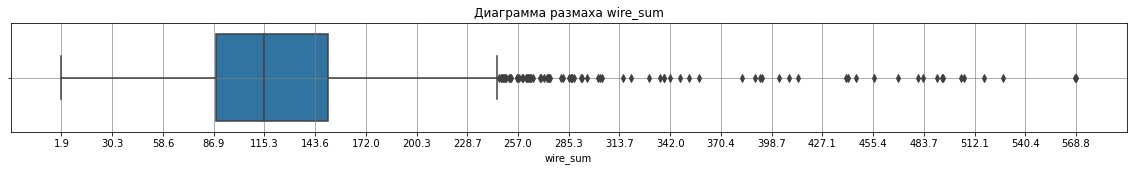

In [237]:
for i in df.drop('key', axis=1).columns:
    plt.rcParams['figure.figsize']=(20, 2)
    sns.boxplot(x=df[f"{i}"])
    plt.title(f"Диаграмма размаха {i}")
    plt.grid(color='grey', axis='both', alpha=.8)
    plt.xticks(np.arange(df[f"{i}"].min(), (df[f"{i}"].max() + df[f"{i}"].max()/35), 
                         ((df[f"{i}"].max() - df[f"{i}"].min()) / 20)))
    plt.show()

Отфильтурем выборсы и выведем их количество в общих данных:

In [239]:
(len(df) - len(df[(df['duration_temp_meas'] <= 7500)
        & (df['energy'] <= 1539)                   
        #& (df['full_power'] <= 5.5) 
        & (df['bulk_3'] <= 300) #важно
        & (df['bulk_4'] <= 240) 
        & (df['bulk_12'] <= 680) 
        & (df['bulk_14'] <= 385) 
        & (df['gas_1'] <= 42) 
        & (df['wire_1'] <= 230) 
        & (df['wire_2'] <= 150)         
        & (df['wire_sum'] <= 380)])) / len(df) 

0.054770318021201414

Удалим 5 % данных с выбросами:

In [240]:
df = df[(df['duration_temp_meas'] <= 7500)
        & (df['energy'] <= 1539)    
        & (df['bulk_3'] <= 310) 
        & (df['bulk_4'] <= 240) 
        & (df['bulk_12'] <= 680) 
        & (df['bulk_14'] <= 385) 
        & (df['gas_1'] <= 42) 
        & (df['wire_1'] <= 230) 
        & (df['wire_2'] <= 150)         
        & (df['wire_sum'] <= 380)]

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2349
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2147 non-null   int64  
 1   temp_first          2147 non-null   float64
 2   temp_last           2147 non-null   float64
 3   duration_temp_meas  2147 non-null   int64  
 4   energy              2147 non-null   float64
 5   bulk_3              2147 non-null   float64
 6   bulk_4              2147 non-null   float64
 7   bulk_12             2147 non-null   float64
 8   bulk_14             2147 non-null   float64
 9   bulk_15             2147 non-null   float64
 10  ratio_bulk_sum      2147 non-null   float64
 11  gas_1               2147 non-null   float64
 12  wire_1              2147 non-null   float64
 13  wire_2              2147 non-null   float64
 14  wire_sum            2147 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 268.4 KB


Выведем конечный DataFrame для обучения моделей:

In [243]:
df.head()

,key,temp_first,temp_last,duration_temp_meas,energy,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,ratio_bulk_sum,gas_1,wire_1,wire_2,wire_sum
0,1,1571.0,1613.0,861,723.156360,0.0,43.0,206.0,150.0,154.0,0.855705,29.749986,60.059998,0.00000,60.059998
1,2,1581.0,1602.0,1305,881.233565,0.0,73.0,206.0,149.0,154.0,0.777099,12.555561,96.052315,0.00000,96.052315
2,3,1596.0,1599.0,1300,525.066777,0.0,34.0,205.0,152.0,153.0,0.882353,28.554793,91.160157,0.00000,91.160157
3,4,1601.0,1601.0,0,796.911309,0.0,81.0,207.0,153.0,154.0,0.760355,18.841219,89.063515,0.00000,89.063515
4,5,1576.0,1602.0,762,397.894477,0.0,78.0,203.0,151.0,152.0,0.764350,5.413692,89.238236,9.11456,98.352796


### Деление на тренировочную и тестовые выборки

Разделим данные на обучаюушую и тестовую выборки, а также выделем целевой признак:

In [244]:
features = df.drop(['temp_last', 'key'], axis=1)
target = df['temp_last']

In [245]:
features_train, features_test = train_test_split(features, test_size=0.20, random_state=42)
target_train, target_test = train_test_split(target, test_size=0.20, random_state=42)

### Вывод 

Проведена предобработка данных, наши изночальные таблицы объеденены в одну, удалены выборсы. Выборка поделена на тренировочную и тестовую для обучения моделей.

## Обучение моделей

### DummyRegressor

In [252]:
%%time
start = time.time()

dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features_train, target_train)

end = time.time()
dummy_fit_time = end - start

CPU times: user 1.53 ms, sys: 81 µs, total: 1.61 ms
Wall time: 1.29 ms


In [280]:
dummy_mae = mean_absolute_error(target_test, dummy_model.predict(features_test))

### LinearRegression

In [ ]:
%%time
start = time.time()

regressor = LinearRegression() 
hyperparams = [{'n_estimators': range (1, 20, 2), 
                'max_depth': np.arange(1, 5, 1, dtype=int), #range (1, 5),
                'random_state': [42]}]

gbr_search = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error')
gbr_search.fit(features_train, target_train)

end = time.time()
gbr_fit_time = end - start

In [253]:
%%time
start = time.time()

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

end = time.time()
lr_fit_time = end - start

CPU times: user 353 ms, sys: 8.01 ms, total: 361 ms
Wall time: 296 ms


In [254]:
predict_lr_model = lr_model.predict(features_test)

In [283]:
lr_mae = mean_absolute_error(target_test, predict_lr_model)

### GradientBoostingRegressor

In [348]:
%%time
start = time.time()

regressor = GradientBoostingRegressor() 
hyperparams = [{'n_estimators' : range (1, 20, 2), 
                'max_depth' : np.arange(1, 5, 1, dtype=int),
               'subsample'    : [0.9, 0.5, 0.2, 0.1],
               'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05]}]

gbr_search = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5)
gbr_search.fit(features_train, target_train)

end = time.time()
gbr_fit_time = end - start

CPU times: user 2.71 s, sys: 121 ms, total: 2.83 s
Wall time: 7.71 s


In [349]:
predict_gbr = gbr_search.predict(features_test)

In [351]:
gbr_mae = mean_absolute_error(target_test, predict_gbr)

### RandomForestRegressor

In [262]:
%%time
start = time.time()

rfr = RandomForestRegressor(random_state=123)

params = {'n_estimators': [100, 150, 300],
          'max_depth': [5, 7, 9],
          'min_samples_leaf' : [1, 2],
          'max_features':['auto'],
          'min_samples_split': [2, 4, 6],
          'random_state':[42]
          }

rfr_model = GridSearchCV(estimator=rfr, param_grid=params, n_jobs=-1, cv=5, scoring='neg_mean_absolute_error')

rfr_model.fit(features_train, target_train)

end = time.time()
rfr_fit_time = end - start

CPU times: user 1.75 s, sys: 289 ms, total: 2.04 s
Wall time: 25.5 s


In [263]:
rfr_model.best_params_

{'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 150,
 'random_state': 42}

In [285]:
rfr_mae = mean_absolute_error(target_test, rfr_model.predict(features_test))

### XGBRegressor

In [265]:
%%time
start = time.time()

xgbr = xgb.XGBRegressor(verbosity=0, random_state=123)

params = {'n_estimators': [100, 150, 200, 300], 
          'learning_rate' : [0.03, 0.05, 0.07, 0.09],
         'max_depth' : [2, 3, 5, 7, 9],
         }

xgbr_model = GridSearchCV(estimator=xgbr, param_grid=params, n_jobs=-1, cv=5, scoring='neg_mean_absolute_error')

xgbr_model.fit(features_train, target_train)

end = time.time()
xgbr_fit_time = end - start

CPU times: user 7.77 s, sys: 306 ms, total: 8.07 s
Wall time: 23 s


In [266]:
xgbr_model.best_params_

{'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 200}

In [327]:
%%time
start = time.time()

xgbr_model = xgb.XGBRegressor(learning_rate = 0.07, max_depth = 3, n_estimators = 200)

xgbr_model.fit(features_train, target_train)

end = time.time()
xgbr_fit_time = end - start  

CPU times: user 6.47 s, sys: 282 ms, total: 6.75 s
Wall time: 461 ms


In [328]:
predict_xgbr = xgbr_model.predict(features_test)

In [329]:
xgbr_mae = mean_absolute_error(target_test, predict_xgbr)

### LGBMRegressor

In [ ]:
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'max_depth': range(10, 11, 10),    
    'num_leaves': range(30, 41, 10),
    'min_data_in_leaf': range(12, 15, 1),   
    'max_bin': range(80, 121, 10),
    'learning_rate': [0.01, 0.02, 0.05],

In [273]:
%%time
start = time.time()

lgbm = ltb.LGBMRegressor(random_state=42)
params_lgbm = { 
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'max_depth': range(10, 11, 10),    
    'num_leaves': range(30, 41, 10),
    'min_data_in_leaf': range(12, 15, 1),   
    'max_bin': range(80, 121, 10),
    'learning_rate': [0.01, 0.02, 0.05],
}    

lgbm_model = GridSearchCV(lgbm, params_lgbm, cv=6, scoring='neg_mean_absolute_error',
                          verbose=1, n_jobs=-1)                 
lgbm_model.fit(features_train, target_train)

end = time.time()
lgbm_fit_time = end - start  

Fitting 6 folds for each of 90 candidates, totalling 540 fits
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignore

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min

CPU times: user 4.89 s, sys: 144 ms, total: 5.03 s
Wall time: 5.34 s


In [274]:
lgbm_model.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'max_bin': 80,
 'max_depth': 10,
 'min_data_in_leaf': 12,
 'num_leaves': 30,
 'objective': 'regression'}

In [288]:
lgbm_mae = mean_absolute_error(target_test, lgbm_model.predict(features_test))

### CatBoostRegressor

In [ ]:
# cbr = CatBoostRegressor()

# parameters = {'verbose' : [10],
#               'early_stopping_rounds' : [5],
#               'random_seed' : [100],
#               'max_depth' : [5, 7],
#               'learning_rate' : [0.02, 0.03, 0.05, 0.07],
#               'iterations' :  [500, 1000],
#               'loss_function' : ['MAE'],
#               'eval_metric' : ['MAE'],
#              }

# cbr_grid = GridSearchCV(estimator=cbr, param_grid=parameters, cv=5, n_jobs=-1)
# cbr_grid.fit(features_train, target_train, eval_set=(features_test, target_test))

In [ ]:
# mean_absolute_error(target_test, cbr_grid.predict(features_test))

In [ ]:
# cbr_grid.best_params_

In [276]:
%%time
start = time.time()

cbr_model = CatBoostRegressor(eval_metric='MAE', loss_function='MAE')

cbr_model.fit(features_train, target_train, eval_set=(features_test, target_test))

end = time.time()
cbr_fit_time = end - start  

0:	learn: 7.5218802	test: 7.1923711	best: 7.1923711 (0)	total: 113ms	remaining: 1m 52s
1:	learn: 7.4822795	test: 7.1643490	best: 7.1643490 (1)	total: 115ms	remaining: 57.4s
2:	learn: 7.4353664	test: 7.1268831	best: 7.1268831 (2)	total: 117ms	remaining: 38.8s
3:	learn: 7.3955866	test: 7.0859210	best: 7.0859210 (3)	total: 119ms	remaining: 29.5s
4:	learn: 7.3536721	test: 7.0469047	best: 7.0469047 (4)	total: 120ms	remaining: 23.9s
5:	learn: 7.3240062	test: 7.0149061	best: 7.0149061 (5)	total: 122ms	remaining: 20.2s
6:	learn: 7.2821530	test: 6.9796937	best: 6.9796937 (6)	total: 124ms	remaining: 17.6s
7:	learn: 7.2484808	test: 6.9544093	best: 6.9544093 (7)	total: 126ms	remaining: 15.6s
8:	learn: 7.2108743	test: 6.9223828	best: 6.9223828 (8)	total: 127ms	remaining: 14s
9:	learn: 7.1722388	test: 6.8989996	best: 6.8989996 (9)	total: 129ms	remaining: 12.8s
10:	learn: 7.1437608	test: 6.8741406	best: 6.8741406 (10)	total: 131ms	remaining: 11.7s
11:	learn: 7.1166900	test: 6.8564121	best: 6.8564121 

148:	learn: 5.5019220	test: 6.0372528	best: 6.0372528 (148)	total: 304ms	remaining: 1.73s
149:	learn: 5.4978424	test: 6.0350629	best: 6.0350629 (149)	total: 305ms	remaining: 1.73s
150:	learn: 5.4949783	test: 6.0350221	best: 6.0350221 (150)	total: 306ms	remaining: 1.72s
151:	learn: 5.4907852	test: 6.0340769	best: 6.0340769 (151)	total: 307ms	remaining: 1.71s
152:	learn: 5.4859961	test: 6.0355517	best: 6.0340769 (151)	total: 308ms	remaining: 1.71s
153:	learn: 5.4811542	test: 6.0342309	best: 6.0340769 (151)	total: 309ms	remaining: 1.7s
154:	learn: 5.4752346	test: 6.0349896	best: 6.0340769 (151)	total: 310ms	remaining: 1.69s
155:	learn: 5.4687865	test: 6.0320378	best: 6.0320378 (155)	total: 311ms	remaining: 1.68s
156:	learn: 5.4619682	test: 6.0305054	best: 6.0305054 (156)	total: 312ms	remaining: 1.68s
157:	learn: 5.4594550	test: 6.0301441	best: 6.0301441 (157)	total: 313ms	remaining: 1.67s
158:	learn: 5.4550601	test: 6.0279834	best: 6.0279834 (158)	total: 314ms	remaining: 1.66s
159:	learn:

326:	learn: 4.7743162	test: 5.9704786	best: 5.9680630 (324)	total: 491ms	remaining: 1.01s
327:	learn: 4.7685462	test: 5.9701504	best: 5.9680630 (324)	total: 492ms	remaining: 1.01s
328:	learn: 4.7652027	test: 5.9701296	best: 5.9680630 (324)	total: 493ms	remaining: 1s
329:	learn: 4.7608323	test: 5.9690661	best: 5.9680630 (324)	total: 494ms	remaining: 1s
330:	learn: 4.7591467	test: 5.9680464	best: 5.9680464 (330)	total: 495ms	remaining: 1s
331:	learn: 4.7545969	test: 5.9683905	best: 5.9680464 (330)	total: 496ms	remaining: 998ms
332:	learn: 4.7527186	test: 5.9683126	best: 5.9680464 (330)	total: 497ms	remaining: 996ms
333:	learn: 4.7491242	test: 5.9679518	best: 5.9679518 (333)	total: 498ms	remaining: 993ms
334:	learn: 4.7453638	test: 5.9688750	best: 5.9679518 (333)	total: 499ms	remaining: 991ms
335:	learn: 4.7410062	test: 5.9690417	best: 5.9679518 (333)	total: 500ms	remaining: 989ms
336:	learn: 4.7375329	test: 5.9684307	best: 5.9679518 (333)	total: 501ms	remaining: 986ms
337:	learn: 4.73477

508:	learn: 4.2448297	test: 5.9977397	best: 5.9542339 (374)	total: 679ms	remaining: 655ms
509:	learn: 4.2419694	test: 5.9953137	best: 5.9542339 (374)	total: 681ms	remaining: 654ms
510:	learn: 4.2398545	test: 5.9974725	best: 5.9542339 (374)	total: 682ms	remaining: 652ms
511:	learn: 4.2385647	test: 5.9975295	best: 5.9542339 (374)	total: 683ms	remaining: 651ms
512:	learn: 4.2374805	test: 5.9971514	best: 5.9542339 (374)	total: 684ms	remaining: 649ms
513:	learn: 4.2357806	test: 5.9978570	best: 5.9542339 (374)	total: 685ms	remaining: 648ms
514:	learn: 4.2339434	test: 5.9974791	best: 5.9542339 (374)	total: 686ms	remaining: 646ms
515:	learn: 4.2315720	test: 5.9975018	best: 5.9542339 (374)	total: 687ms	remaining: 644ms
516:	learn: 4.2286728	test: 5.9977176	best: 5.9542339 (374)	total: 688ms	remaining: 643ms
517:	learn: 4.2242737	test: 5.9983438	best: 5.9542339 (374)	total: 689ms	remaining: 641ms
518:	learn: 4.2231591	test: 5.9985423	best: 5.9542339 (374)	total: 690ms	remaining: 640ms
519:	learn

690:	learn: 3.9085586	test: 6.0090545	best: 5.9542339 (374)	total: 867ms	remaining: 388ms
691:	learn: 3.9070379	test: 6.0082627	best: 5.9542339 (374)	total: 868ms	remaining: 386ms
692:	learn: 3.9052694	test: 6.0094956	best: 5.9542339 (374)	total: 869ms	remaining: 385ms
693:	learn: 3.9042330	test: 6.0094819	best: 5.9542339 (374)	total: 870ms	remaining: 384ms
694:	learn: 3.9024261	test: 6.0084126	best: 5.9542339 (374)	total: 871ms	remaining: 382ms
695:	learn: 3.8996351	test: 6.0107971	best: 5.9542339 (374)	total: 872ms	remaining: 381ms
696:	learn: 3.8982784	test: 6.0101738	best: 5.9542339 (374)	total: 874ms	remaining: 380ms
697:	learn: 3.8961923	test: 6.0102951	best: 5.9542339 (374)	total: 875ms	remaining: 378ms
698:	learn: 3.8940770	test: 6.0090255	best: 5.9542339 (374)	total: 876ms	remaining: 377ms
699:	learn: 3.8911737	test: 6.0087836	best: 5.9542339 (374)	total: 877ms	remaining: 376ms
700:	learn: 3.8906978	test: 6.0086435	best: 5.9542339 (374)	total: 878ms	remaining: 374ms
701:	learn

873:	learn: 3.6629188	test: 6.0276467	best: 5.9542339 (374)	total: 1.06s	remaining: 152ms
874:	learn: 3.6618350	test: 6.0274932	best: 5.9542339 (374)	total: 1.06s	remaining: 151ms
875:	learn: 3.6612069	test: 6.0276063	best: 5.9542339 (374)	total: 1.06s	remaining: 150ms
876:	learn: 3.6602451	test: 6.0273231	best: 5.9542339 (374)	total: 1.06s	remaining: 149ms
877:	learn: 3.6593676	test: 6.0276731	best: 5.9542339 (374)	total: 1.06s	remaining: 148ms
878:	learn: 3.6575932	test: 6.0275371	best: 5.9542339 (374)	total: 1.06s	remaining: 146ms
879:	learn: 3.6561041	test: 6.0268118	best: 5.9542339 (374)	total: 1.06s	remaining: 145ms
880:	learn: 3.6556600	test: 6.0272115	best: 5.9542339 (374)	total: 1.06s	remaining: 144ms
881:	learn: 3.6529698	test: 6.0279363	best: 5.9542339 (374)	total: 1.07s	remaining: 143ms
882:	learn: 3.6516488	test: 6.0280442	best: 5.9542339 (374)	total: 1.07s	remaining: 141ms
883:	learn: 3.6498977	test: 6.0276269	best: 5.9542339 (374)	total: 1.07s	remaining: 140ms
884:	learn

CPU times: user 11.2 s, sys: 1.94 s, total: 13.1 s
Wall time: 2.44 s


In [278]:
predictions_valid = cbr_model.predict(features_test)

In [289]:
cbr_mae = mean_absolute_error(target_test, predictions_valid)

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min

## Анализ моделей

### Вывод результатов моделирования

Составим таблицу с результатами обучения (добавим метрику и время обучения)

In [305]:
model_results = {
                'MAE_score': [dummy_mae, lr_mae, gbr_mae, rfr_mae, xgbr_mae, lgbm_mae, cbr_mae],
                'fit_time, sec': [dummy_fit_time, lr_fit_time, gbr_fit_time, 
                                  rfr_fit_time, xgbr_fit_time, lgbm_fit_time, cbr_fit_time]
                 }

In [306]:
results = pd.DataFrame(data=model_results, index=('DummyRegressor', 'LinearRegression', 'GradientBoostingRegressor',
                                                  'RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor',
                                                 'CatBoostRegressor'))

In [307]:
results.sort_values(by='MAE_score')

,MAE_score,"fit_time, sec"
CatBoostRegressor,5.954235,2.439004
XGBRegressor,6.188587,22.976483
RandomForestRegressor,6.195345,25.511557
LinearRegression,6.220293,5.715271
LGBMRegressor,6.288771,5.342953
GradientBoostingRegressor,6.380545,5.689794
DummyRegressor,7.218605,0.001266


### Важность признаков

Определим функцию для построения графика вжаности признаков:

In [337]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10, 5))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.grid(color='grey', axis='both', alpha=.6)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

Посмотрим на важность признаков для CatBoostRegressor и для XGBRegressor (наши две топ-2 модели):

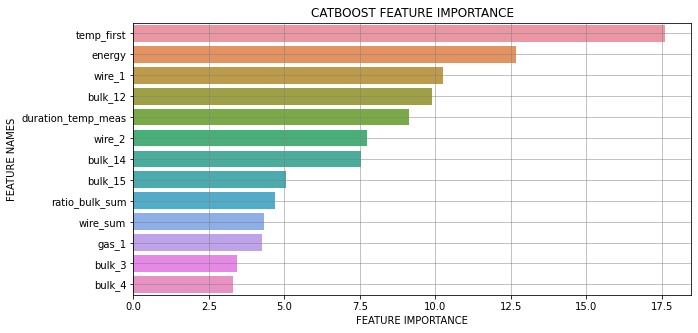

In [339]:
plot_feature_importance(cbr_model.get_feature_importance(),features.columns,'CATBOOST ')

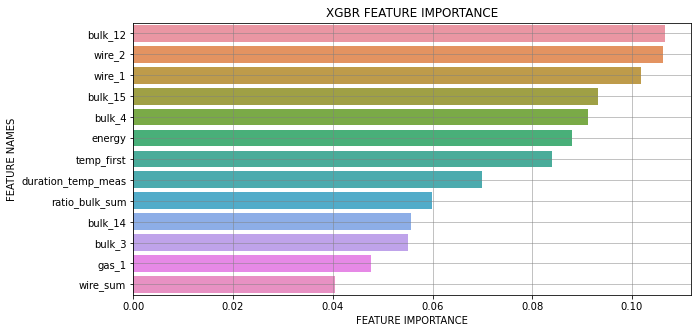

In [340]:
plot_feature_importance(xgbr_model.feature_importances_,features.columns,'XGBR ')

## Вывод

В ходе работы была проведена предобработка данных, объеденения данных в один DataFrame.  
Обучены модели, с лучше метрикой MAE у CatBoostRegressor `5.95`. Наиболее важные признаки для модели CatBoostReegressor, это первая температура замера, энергия, проволока Wire 1 и сыпучий материал Bulk 12.